In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)

import pandas as pd
import numpy as np
import tflscripts
import json
import pickle
from tflscripts import boxplot_by, scatter_plot_by, heatmap_by

configuration = tflscripts.read_configuration()
df = pd.read_pickle('results.p')

In [3]:
df['devices'] = [row['source_device'] + '->' + row['target_device'] for i, row in df.iterrows()]
df['device_types'] = [row['source_device_type'] + '->' + row['target_device_type'] for i, row in df.iterrows()]
df['replica'] = ['Replica' if row['source_device'] == row['target_device'] else 'Not replica' for i, row in df.iterrows()]
df['samples_r'] = np.round(df.samples.values / 10) * 10

In [4]:
df_transfer = df.loc[df.type_of_transfer != 'No transfer']

without_transfer = df.loc[df.type_of_transfer == 'No transfer']
without_transfer_mites = without_transfer.loc[df.source_device_type == 'Mite']

df_transfer_synergy = df_transfer.loc[(df_transfer.source_room == 'synergy') & (df_transfer.target_room == 'synergy')]
df_transfer_synergy_mite = df_transfer_synergy.loc[(df_transfer.source_device_type == 'Mite') & (df_transfer.target_device_type == 'Mite')]

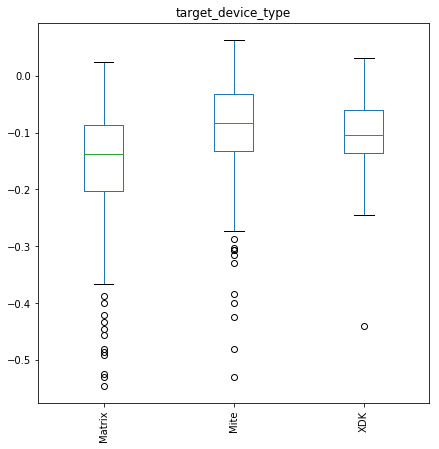

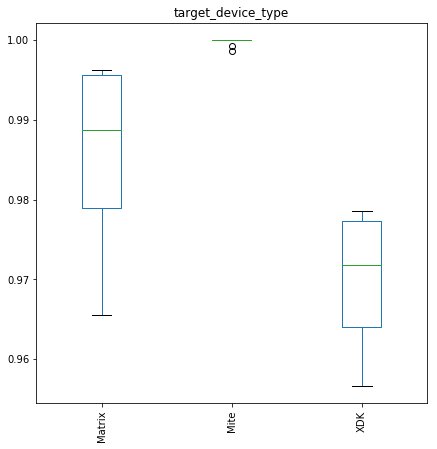

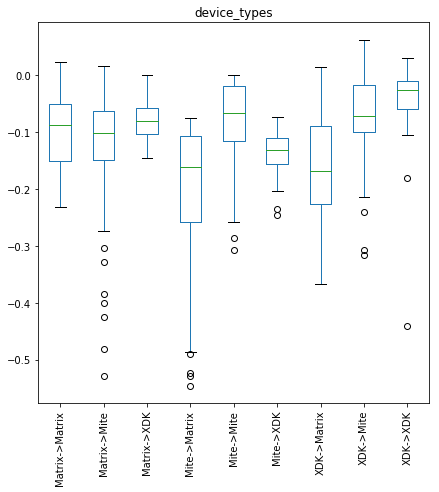

In [5]:
plt.rcParams["figure.figsize"] = (7, 7)

features = 'Microphone'
label = 'Blender running'
value_column = 'accuracy_change'
classifier='RandomForestClassifier'

boxplot_by('target_device_type', value_column=value_column, label=label, features=features, classifier=classifier, df_plot=df_transfer)
boxplot_by('target_device_type', value_column='specificity', label=label, features=features, df_plot=without_transfer, classifier=classifier)
boxplot_by('device_types', value_column=value_column, label=label, features='Microphone', df_plot=df_transfer, classifier=classifier)

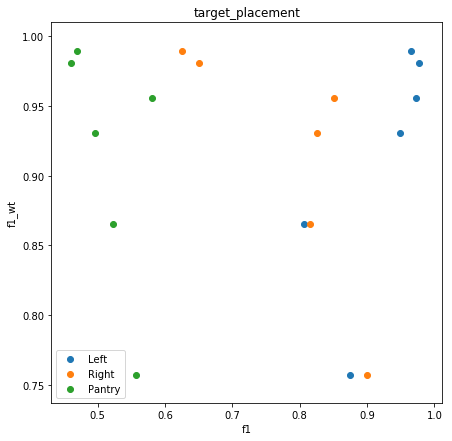

In [7]:
x_value_column = 'f1'
y_value_column = 'f1_wt'
label='Dishes'
features='All'

df_transfer = df.loc[df.type_of_transfer != 'No transfer']

without_transfer = df.loc[df.type_of_transfer == 'No transfer']
without_transfer_mites = without_transfer.loc[df.source_device_type == 'Mite']

df_plot = df_transfer.loc[(df_transfer.source_room == 'synergy') & (df_transfer.target_room == 'scott')]
df_plot = df_plot.loc[(df_transfer.source_device_type == 'Mite') & (df_transfer.target_device_type == 'Mite')]

scatter_plot_by('target_placement', x_value_column=x_value_column, y_value_column=y_value_column,
                common_limits=False, label=label, features=features, df_plot=df_plot)

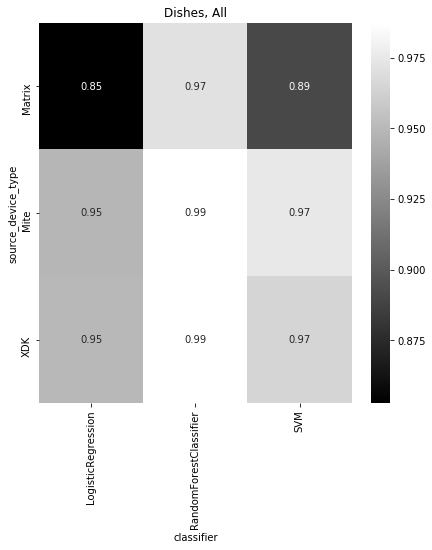

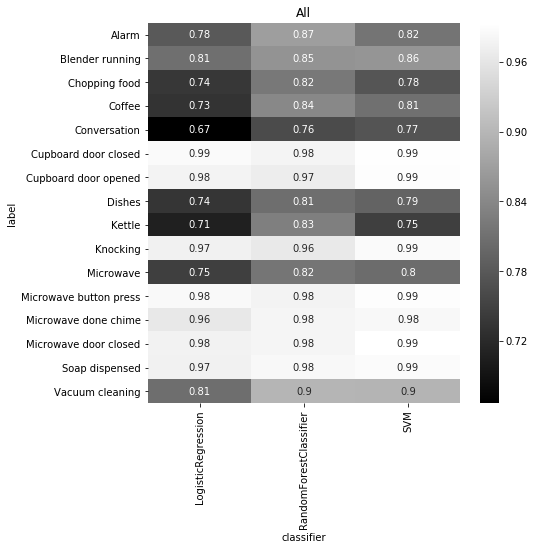

In [7]:
value_column = 'accuracy'
heatmap_by('classifier', 'source_device_type', value_column, label='Dishes', features='All', classifier=None, df_plot=without_transfer)
heatmap_by('classifier', 'label', value_column, label=None, features='All', classifier=None, df_plot=df_transfer)

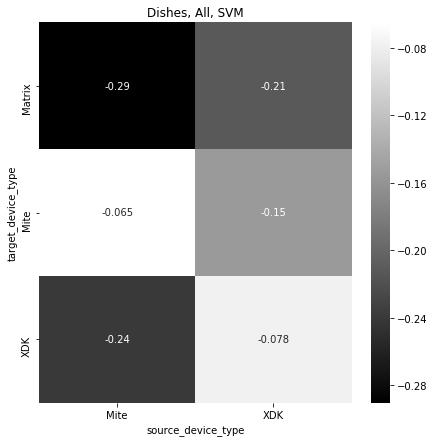

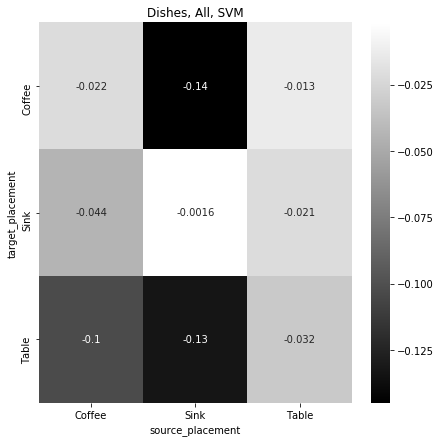

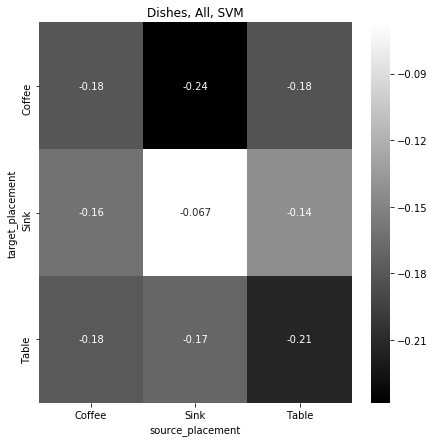

In [8]:
value_column = 'accuracy_change'

heatmap_by('source_device_type', 'target_device_type', value_column, label='Dishes', features='All', classifier='SVM',
           df_plot=df_transfer_synergy)

heatmap_by('source_placement', 'target_placement', value_column, label='Dishes', features='All', classifier='SVM',
           df_plot=df_transfer_synergy_mite)

heatmap_by('source_placement', 'target_placement', value_column, label='Dishes', features='All', classifier='SVM',
           df_plot=df_transfer_synergy)

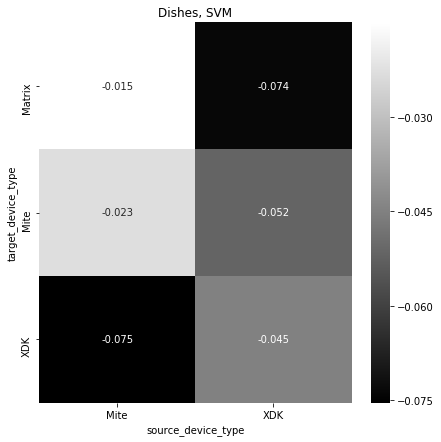

In [69]:
only_best = df.sort_values(by='accuracy', ascending=False)
only_best = only_best.drop_duplicates(['source_dataset', 'target_dataset', 'source_device', 'target_device', 'label'], keep='first')
only_best_transfer = only_best.loc[only_best.type_of_transfer != 'No transfer']

only_best_transfer_synergy = only_best_transfer.loc[(only_best_transfer.source_room == 'synergy') & (only_best_transfer.target_room == 'synergy')]

heatmap_by('source_device_type', 'target_device_type', 'accuracy_change', label='Dishes', features=None, classifier='SVM',
           df_plot=only_best_transfer_synergy)

In [64]:
only_best

,source_dataset,target_dataset,source_device_id,target_device_id,source_device,target_device,source_device_name,target_device_name,source_device_type,target_device_type,...,features_name,accuracy,accuracy_positive,accuracy_negative,accuracy_wt,accuracy_positive_wt,accuracy_negative_wt,accuracy_change,accuracy_positive_change,accuracy_negative_change
176890,robotics-final,robotics-final,Matrix b827eb96f31a,Matrix b827eb96f31a,Matrix 1,Matrix 1,Matrix 1 Sink,Matrix 1 Sink,Matrix,Matrix,...,Accelerometer & magnetometer,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
13725,scott-final-iter3,scott-final-iter3,128.237.250.218,128.237.227.76,Mite 4,Mite 2,Mite 4 Right,Mite 2 Left,Mite,Mite,...,All,1.000000,1.000000,1.000000,0.997800,0.984848,1.000000,0.002200,0.015152,0.000000
140267,synergy-final-iter5,synergy-final-iter5,128.237.250.218,128.237.250.218,Mite 4,Mite 4,Mite 4 Sink,Mite 4 Sink,Mite,Mite,...,EMI & motion,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
48342,scott-final-iter1,scott-final-iter1,128.237.247.134,128.237.248.186,Mite 4,Mite 2,Mite 4 Right,Mite 2 Left,Mite,Mite,...,Microphone & accelerometer,1.000000,1.000000,1.000000,0.998768,0.991150,1.000000,0.001232,0.008850,0.000000
72986,synergy-final-iter4,synergy-final-iter4,128.237.227.76,128.237.250.218,Mite 2,Mite 4,Mite 2 Sink,Mite 4 Coffee,Mite,Mite,...,Microphone,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
96728,synergy-final-iter1,synergy-final-iter2,128.237.248.186,128.237.248.186,Mite 2,Mite 2,Mite 2 Table,Mite 2 Sink,Mite,Mite,...,All,1.000000,1.000000,1.000000,0.996568,0.571429,1.000000,0.003432,0.428571,0.000000
96434,synergy-final-iter1,synergy-final-iter1,128.237.248.186,128.237.248.186,Mite 2,Mite 2,Mite 2 Table,Mite 2 Table,Mite,Mite,...,All,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
81382,synergy-final-iter4,synergy-final-iter4,128.237.250.218,128.237.250.218,Mite 4,Mite 4,Mite 4 Coffee,Mite 4 Coffee,Mite,Mite,...,Microphone & accelerometer,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
88625,synergy-final-iter1,synergy-final-iter1,128.237.246.127,128.237.246.127,Mite 1,Mite 1,Mite 1 Coffee,Mite 1 Coffee,Mite,Mite,...,EMI & motion,1.000000,1.000000,1.000000,0.998703,0.992216,0.999839,0.001297,0.007784,0.000161
48225,scott-final-iter1,scott-final-iter1,128.237.247.134,128.237.247.134,Mite 4,Mite 4,Mite 4 Right,Mite 4 Right,Mite,Mite,...,Microphone,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
